In [1]:
import pandas as pd
import numpy as np
import nltk
import gensim
import string
import math
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout, Activation, GRU
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

Using TensorFlow backend.


#  第一阶段 #

In [2]:
train = pd.read_csv("train.txt", sep='\t')
test = pd.read_csv("test.txt", sep='\t')

all_Data = train.append(test)
all_Data['ID'] = [i for i in range(1, len(all_Data) + 1)]
all_Data = all_Data[['ID', 'Title', 'Abstract']]

# 处理Abstract nan
all_Data.loc[all_Data["Abstract"].isnull(), 'Abstract'] = all_Data[all_Data["Abstract"].isnull()]['Title']
all_command = all_Data.Abstract.map(lambda x: x.lstrip().rstrip())

train['Event ID'] = train['Event ID'].fillna(0)
train_Y = [1 if iden > 0 else 0 for iden in train['Event ID'] ]

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
all_Data

,ID,Title,Abstract
0,1,New dog food recall and latest warning on grai...,New dog food recall and latest warning on grai...
1,2,New Dog Food Recall And The Latest Warning On ...,New Dog Food Recall And The Latest Warning On ...
2,3,RT @BaybeeReade: Another dog food recall over ...,RT @BaybeeReade: Another dog food recall over ...
3,4,Hill’s Pet Nutrition voluntary recall affects ...,Hill’s Pet Nutrition voluntary recall affects ...
4,5,RT @mercnews: New dog food recall and the late...,RT @mercnews: New dog food recall and the late...
5,6,ICYMI #Recall Alert for Dog Food,ICYMI #Recall Alert for Dog Food https://t.co/...
6,7,Another Big Dog Food Recall,Another Big Dog Food Recall https://t.co/ycE55...
7,8,Canned Dog Food recall alert! Science Diet has...,Canned Dog Food recall alert! Science Diet has...
8,9,"@Al_Martell Great question, the voluntary reca...","@Al_Martell Great question, the voluntary reca..."
9,10,"Another dog food recall, this time over concer...","Another dog food recall, this time over concer..."


In [4]:
handle_all_command = []
lines = all_command.tolist()
stopwords = set(nltk.corpus.stopwords.words("english"))
table = str.maketrans("","",string.punctuation)
for line in lines:
    line = " ".join([word for word in line.split(" ") if '@' not in word and 'http' not in word and "RT" not in word])
    tokens = nltk.word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    tokens = [w.translate(table) for w in tokens]
    tokens = [w for w in tokens if w.isalpha()]
    tokens = [w for w in tokens if w not in stopwords and w ]
    handle_all_command.append(tokens)
    
all_Data['handled'] = [" ".join(s) for s in handle_all_command]

In [5]:
embedding_size = 150
word2vec = gensim.models.Word2Vec(sentences=handle_all_command, 
                                  size=embedding_size,
                                  min_count=1, 
                                  window=5)

In [6]:
# length = [len(x) for x in handle_all_command if len(x) > 10]
# max_len = math.ceil(sum(length) / len(length))
max_len = 30

In [7]:
common_words = 6000
tokenizer = Tokenizer(num_words=common_words)
tokenizer.fit_on_texts(handle_all_command)
sequence = tokenizer.texts_to_sequences(handle_all_command)
handle_all_command = pad_sequences(sequence, maxlen=max_len)

In [8]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in tokenizer.word_index.items():
    em_vector = word2vec.wv[word]
    if em_vector is not None:
        embedding_matrix[i] = em_vector

In [9]:
X = handle_all_command[: len(train), :]
Y = train_Y
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.0, random_state=42, shuffle=True)

In [10]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_size, 
                    input_length=max_len, 
                    weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 150)           4517550   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               110080    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 4,628,931
Trainable params: 4,628,931
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, Y_train, 
                    epochs=5, batch_size=128, 
                    callbacks = [learning_rate_reduction])

Epoch 1/5
4183/4183 [==============================] - 8s 2ms/step - loss: 0.4219 - acc: 0.7767
Epoch 2/5
 128/4183 [..............................] - ETA: 3s - loss: 0.2172 - acc: 0.9219

C:\Users\LeiYu\AppData\Roaming\Python\Python36\site-packages\keras\callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4183/4183 [==============================] - 4s 1ms/step - loss: 0.1514 - acc: 0.9486
Epoch 3/5
4183/4183 [==============================] - 4s 1ms/step - loss: 0.1213 - acc: 0.9584
Epoch 4/5
4183/4183 [==============================] - 4s 980us/step - loss: 0.0873 - acc: 0.9716
Epoch 5/5
4183/4183 [==============================] - 4s 987us/step - loss: 0.0738 - acc: 0.9763


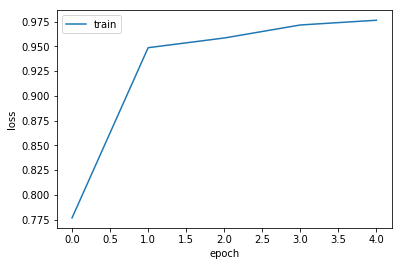

In [12]:
# loss
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# loss + val
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [13]:
y_pred = model.predict(handle_all_command[len(train):len(train) + len(test), :])

In [14]:
ypred = [1 if x > 0.5 else 0 for x in y_pred]

In [15]:
tt = pd.Series(ypred)
tt.value_counts()

0    20502
1     2338
dtype: int64

In [16]:
testData = all_Data[len(train):]
testData['pred'] = ypred

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
testData

,ID,Title,Abstract,handled,pred
0,4184,@pccs_heron Salmonella,@pccs_heron Salmonella,salmonella,0
1,4185,@richardlanigan @trishgreenhalgh No. It's not ...,@richardlanigan @trishgreenhalgh No. It's not ...,feaces alone polio virus transmitted,0
2,4186,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,thought allergic water,0
3,4187,20 percent of seafood is mislabeled! Global fo...,20 percent of seafood is mislabeled! Global fo...,percent seafood mislabeled global food safety ...,0
4,4188,#EuropeanCourt decided that #foodsafety and #e...,#EuropeanCourt decided that #foodsafety and #e...,europeancourt decided foodsafety environmental...,0
5,4189,@caityrogo I play it pretty fast and loose wit...,@caityrogo I play it pretty fast and loose wit...,play pretty fast loose food safety culinary ma...,0
6,4190,RT @ECONewZealand: Kauri dieback - lots of cha...,RT @ECONewZealand: Kauri dieback - lots of cha...,kauri dieback lots challenges questions consul...,0
7,4191,i just ate a clump of MSG from my halal and i ...,i just ate a clump of MSG from my halal and i ...,ate clump msg halal think counts food poisoning,0
8,4192,@zekikayahan Salmonella do?rusu. L* klavye hat...,@zekikayahan Salmonella do?rusu. L* klavye hat...,salmonella rusu l klavye hatas,0
9,4193,@samhinzx Food poisoning is quick and painful ...,@samhinzx Food poisoning is quick and painful ...,food poisoning quick painful fine weekends don...,0


In [30]:
testData.to_csv('res_1state.csv', index = False, sep=',')

# 第二阶段 #

In [31]:
LDA_data = testData[testData['pred'] == 1]

In [33]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

In [36]:
LDA_string = [s.split(' ') for s in LDA_data['handled']]
dic = Dictionary(LDA_string)

[['flying',
  'dallas',
  'fort',
  'worth',
  'airport',
  'thursday',
  'march',
  'check',
  'flight',
  'time',
  'dfw'],
 ['wtol',
  'water',
  'additive',
  'recalled',
  'potentially',
  'deadly',
  'bacteria',
  'dailyrecall',
  'recalls',
  'via'],
 ['kalytera',
  'announces',
  'initiation',
  'study',
  'food',
  'effect',
  'study',
  'kalytera',
  'therapeutics',
  'inc',
  'tsxvkaly',
  'otckaltf',
  'company'],
 ['fda',
  'says',
  'canadian',
  'company',
  'canarx',
  'sells',
  'unsafe',
  'medicines',
  'us',
  'buyers'],
 ['flying',
  'miami',
  'intl',
  'airport',
  'thursday',
  'march',
  'check',
  'flight',
  'time',
  'mia'],
 ['flying',
  'washington',
  'dulles',
  'airport',
  'thursday',
  'march',
  'check',
  'flight',
  'time',
  'iad'],
 ['fruit',
  'juices',
  'contain',
  'high',
  'levels',
  'sugar',
  'detectable',
  'levels',
  'arsenic',
  'lead',
  'yes',
  'includes'],
 ['volkswagen', 'recall', 'information', 'march', 'recalls'],
 ['making', 

In [37]:
dic = Dictionary(LDA_string)

In [39]:
corpus = [dic.doc2bow(text) for text in LDA_string]

In [44]:
lda = LdaModel(corpus=corpus, id2word=dic, num_topics=200) 

In [45]:
lda.print_topics(num_topics=10, num_words=10)

[(83,
  '0.117*"still" + 0.100*"fda" + 0.058*"consumer" + 0.050*"notice" + 0.046*"pillsbury" + 0.044*"recalled" + 0.040*"allpurpose" + 0.040*"flour" + 0.034*"recall" + 0.034*"unbleached"'),
 (67,
  '0.099*"en" + 0.035*"flour" + 0.035*"salmonella" + 0.034*"pillsbury" + 0.033*"recalled" + 0.023*"due" + 0.017*"listeria" + 0.012*"à" + 0.012*"packages" + 0.012*"nearly"'),
 (73,
  '0.133*"turkey" + 0.124*"ground" + 0.120*"butterball" + 0.116*"salmonella" + 0.109*"pounds" + 0.089*"recalls" + 0.059*"recall" + 0.055*"due" + 0.047*"concerns" + 0.035*"possible"'),
 (3,
  '0.066*"tampering" + 0.059*"pork" + 0.054*"product" + 0.054*"readytoeat" + 0.047*"process" + 0.047*"shelfstable" + 0.047*"heattreated" + 0.046*"due" + 0.044*"production" + 0.043*"recalled"'),
 (18,
  '0.099*"recall" + 0.062*"voluntarily" + 0.053*"flour" + 0.053*"pillsbury" + 0.045*"salmonella" + 0.033*"due" + 0.020*"recalled" + 0.018*"food" + 0.016*"pounds" + 0.016*"concerns"'),
 (7,
  '0.103*"march" + 0.095*"friday" + 0.095*"fly

In [6]:
extra = pd.read_csv("first_600_in_test.csv")


In [13]:
extra.iloc[4].Abstract

'#EuropeanCourt decided that #foodsafety and #environmental aspects are more important than the corporate rights to… https://t.co/Q9nZrht3gl'

In [ ]:
nltk.tokenize.t